# Android Compatibility Check Analysis

## Import and Configuration

In [1]:
import datetime
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
from pydriller import RepositoryMining
import re

In [2]:
mpl.rcParams['figure.figsize'] = [50.0, 20.0]
font = {'weight' : 'bold',
        'size'   : 30}
rc('font', **font)

## Data Loading

In [3]:
detected_version_checks_validate = pd.read_csv("../../data/C_Validation_Compatibility_Check_Detection/compat_check_detection_validation_2020_12_11.csv",sep=',',encoding='utf-8')
detected_version_checks_validate_new = pd.read_csv("../../data/C_Validation_Compatibility_Check_Detection/compat_check_detection_validation_2021_01_06.csv",sep=',',encoding='utf-8')
assessor1_analysis = pd.read_csv("../../data/B_Manual_Commit_Analysis/commits_android_messages_assessor1_2020_10-11.csv",sep=';',encoding='unicode_escape')
assessor2_analysis = pd.read_csv("../../data/B_Manual_Commit_Analysis/commits_android_messages_assessor2_2020_10-11.csv",sep=';',encoding='unicode_escape')
assessor3_analysis = pd.read_csv("../../data/B_Manual_Commit_Analysis/commits_android_messages_assessor3_2020_10-11.csv",sep=';',encoding='unicode_escape')
detected_version_checks_full = pd.read_csv("../../data/D_AndroidCompass/AndroidCompass_prelim_2021_01_06.csv",sep=',',encoding='utf-8')

## Validation Compatibility Check Detection

In [4]:
commitsWithMisuse = []
commitsWithCheck = []
commitsWithoutCheck = []
commitsWithMisuse.extend(assessor1_analysis[(assessor1_analysis["is_android_specific_misuse"]=="yes")]["commit"].tolist())
commitsWithCheck.extend(assessor1_analysis[(assessor1_analysis["is_android_specific_misuse"]=="yes") & (assessor1_analysis["is_android_version-compat_check"]=="yes")]["commit"].tolist())
commitsWithoutCheck.extend(assessor1_analysis[(assessor1_analysis["is_android_specific_misuse"]=="yes") & (assessor1_analysis["is_android_version-compat_check"]!="yes")]["commit"].tolist())
commitsWithMisuse.extend(assessor2_analysis[(assessor2_analysis["is_android_specific_misuse"]=="yes")]["commit"].tolist())
commitsWithCheck.extend(assessor2_analysis[(assessor2_analysis["is_android_specific_misuse"]=="yes") & (assessor2_analysis["is_android_version-compat_check"]=="yes")]["commit"].tolist())
commitsWithoutCheck.extend(assessor2_analysis[(assessor2_analysis["is_android_specific_misuse"]=="yes") & (assessor2_analysis["is_android_version-compat_check"]!="yes")]["commit"].tolist())
commitsWithMisuse.extend(assessor3_analysis[(assessor3_analysis["is_android_specific_misuse"]=="yes")]["commit"].tolist())
commitsWithCheck.extend(assessor3_analysis[(assessor3_analysis["is_android_specific_misuse"]=="yes") & (assessor3_analysis["is_android_version-compat_check"]=="yes")]["commit"].tolist())
commitsWithoutCheck.extend(assessor3_analysis[(assessor3_analysis["is_android_specific_misuse"]=="yes") & (assessor3_analysis["is_android_version-compat_check"]!="yes")]["commit"].tolist())

print("#commitsWithMisuse {}".format(len(commitsWithMisuse)))
print("#commitsWithCheck {}".format(len(commitsWithCheck)))
print("#commitsWithoutCheck {}".format(len(commitsWithoutCheck)))

#commitsWithMisuse 132
#commitsWithCheck 67
#commitsWithoutCheck 65


In [5]:
def compute_precision_and_recall(validate_df,commitsWithCheck,commitsWithoutCheck):
    count_tp = 0
    for commit in commitsWithCheck:
        if validate_df["commit_hash"].str.startswith(commit).any():
            #print("found commit {}".format(commit))
            count_tp += 1
        else:
            print("didn't find commit {}".format(commit))
    print("recall: {}".format(count_tp/len(commitsWithCheck)))
    count_fp = 0
    for commit in commitsWithoutCheck:
        if validate_df["commit_hash"].str.startswith(commit).any():
            count_fp += 1 
            print("falsely found commit {}".format(commit))
    print("precision: {}".format(count_tp/(count_tp+count_fp)))

In [6]:
print("validation 2020-12-11")
compute_precision_and_recall(detected_version_checks_validate,commitsWithCheck,commitsWithoutCheck)

print()
print("validation 2021-01-06")
compute_precision_and_recall(detected_version_checks_validate_new,commitsWithCheck,commitsWithoutCheck)

validation 2020-12-11
didn't find commit b9866a9
didn't find commit 3fac478
didn't find commit ae2294c
didn't find commit 210bf89
didn't find commit ad6c4cb
didn't find commit cb184bb
didn't find commit fecda31
didn't find commit b22c719
didn't find commit 5bac94a
didn't find commit f2a5ad5
didn't find commit 72bf7a0
didn't find commit 4c0eb31
didn't find commit 95e535f
didn't find commit bef518e
didn't find commit 30aa3d7
didn't find commit 22e23c8
didn't find commit 6bc7147
didn't find commit efb7c28
recall: 0.7313432835820896
falsely found commit 1bdb45a
precision: 0.98

validation 2021-01-06
didn't find commit 3fac478
didn't find commit ae2294c
didn't find commit 210bf89
didn't find commit ad6c4cb
didn't find commit cb184bb
didn't find commit fecda31
didn't find commit b22c719
didn't find commit 5bac94a
didn't find commit f2a5ad5
didn't find commit 72bf7a0
didn't find commit 4c0eb31
didn't find commit 95e535f
didn't find commit 30aa3d7
didn't find commit 22e23c8
didn't find commit 

Commit 1bdb45a was falsely assessed by assessor 1.

In [7]:
action_counts = detected_version_checks_validate_new.groupby(["repo_name","change_action"])["change_action"].size().reset_index(name='counts')
actions_list = []
for repo in detected_version_checks_validate_new["repo_name"].unique():
    num_add = 0
    add_df = action_counts[(action_counts["repo_name"]==repo) & (action_counts["change_action"]=="+++")].reset_index()
    if(not add_df.empty):
        num_add = add_df["counts"][0]
    num_del = 0
    del_df = action_counts[(action_counts["repo_name"]==repo) & (action_counts["change_action"]=="---")].reset_index()
    if(not del_df.empty):
        num_del = del_df["counts"][0]
    actions_list.append({
                        "repo": repo,
                        "num_added": num_add,
                        "num_deleted": num_del
                        })

prop_added = [(d["repo"],d["num_added"]/(d["num_added"]+d["num_deleted"])) for d in actions_list]
sorted(prop_added, key=lambda tup:tup[1])

[('Battery-Indicator-Pro', 0.4666666666666667),
 ('FRCAndroidWidget', 0.5),
 ('MHGenDatabase', 0.5),
 ('worldscope', 0.5),
 ('AdAway', 0.5039370078740157),
 ('Dir', 0.509090909090909),
 ('episodes', 0.5126050420168067),
 ('Standalone-Calendar', 0.5135135135135135),
 ('Omni-Notes', 0.5137844611528822),
 ('reader', 0.5172413793103449),
 ('Transportr', 0.5185185185185185),
 ('OpenLinkWith', 0.5238095238095238),
 ('andFHEM', 0.5258620689655172),
 ('UniPatcher', 0.5263157894736842),
 ('apps-android-commons', 0.536036036036036),
 ('transdroid', 0.5370370370370371),
 ('apps-android-wikipedia', 0.5372093023255814),
 ('birthday-calendar', 0.5384615384615384),
 ('freemobilenetstat', 0.5386819484240688),
 ('andstatus', 0.5397727272727273),
 ('DroidPersianCalendar', 0.540625),
 ('gobandroid', 0.5416666666666666),
 ('android-money-manager-ex', 0.5427927927927928),
 ('sudowars', 0.5454545454545454),
 ('radiocells-scanner-android', 0.5461538461538461),
 ('Wifi-Fixer', 0.5486725663716814),
 ('voicenot

## Extension of the AndroidCompass Dataset

In [8]:
NONE_DETECTED="NONE_DETECTED"
regexStringA = "^((?!VERSION.SDK_INT).)*(([a-zA-Z0-9\.]*)VERSION.SDK_INT[ ]*(<|<=|==|>=|>)[ ]*([a-zA-Z0-9\._]+))((?!VERSION.SDK_INT).)*$"
regexStringB = "(^|^((?!VERSION.SDK_INT).)*[^a-zA-Z0-9\._])(([a-zA-Z0-9\._]+)[ ]*(<|<=|==|>=|>)[ ]*([a-zA-Z0-9\.]*)VERSION.SDK_INT)((?!VERSION.SDK_INT).)*$"
regexA = re.compile(regexStringA)
regexB = re.compile(regexStringB)

android_versions={
                  "BASE","BASE_1_1","CUPCAKE","DONUT","ECLAIR","ECLAIR_0_1","FROYO",
                  "GINGERBREAD","GINGERBREAD_MR1","HONEYCOMB","HONEYCOMB_MR1","HONEYCOMB_MR2",
                  "ICE_CREAM_SANDWICH","ICE_CREAM_SANDWICH_MR1","JELLY_BEAN","JELLY_BEAN_MR1",
                  "JELLY_BEAN_MR2","KITKAT","KITKAT_WATCH","LOLLIPOP","LOLLIPOP_MR1","M","N",
                  "N_MR1","O","O_MR1","P","Q","R","CUR_DEVELOPMENT" 
                 }

def normalize_package(ver):
    if(ver.endswith("VERSION_CODES.")):
        return NONE_DETECTED
    if(ver.startswith("android.os.Build.VERSION_CODES.")):
        return ver.replace("android.os.","")
    elif(ver.startswith("Build.VERSION_CODES.")):
        return ver
    elif(ver.startswith("VERSION_CODES.")):
        return "Build."+ver
    elif(ver in android_versions):
        return "Build.VERSION_CODES."+ver
    else:
        return NONE_DETECTED

def convert_version(num):
    #taken from https://developer.android.com/reference/android/os/Build.VERSION_CODES
    switcher = {
        1: "Build.VERSION_CODES.BASE",
        2: "Build.VERSION_CODES.BASE_1_1",
        3: "Build.VERSION_CODES.CUPCAKE",
        4: "Build.VERSION_CODES.DONUT",
        5: "Build.VERSION_CODES.ECLAIR",
        6: "Build.VERSION_CODES.ECLAIR_0_1",
        7: "Build.VERSION_CODES.ECLAIR_MR1",
        8: "Build.VERSION_CODES.FROYO",
        9: "Build.VERSION_CODES.GINGERBREAD",
        10: "Build.VERSION_CODES.GINGERBREAD_MR1",
        11: "Build.VERSION_CODES.HONEYCOMB",
        12: "Build.VERSION_CODES.HONEYCOMB_MR1",
        13: "Build.VERSION_CODES.HONEYCOMB_MR2",
        14: "Build.VERSION_CODES.ICE_CREAM_SANDWICH",
        15: "Build.VERSION_CODES.ICE_CREAM_SANDWICH_MR1",
        16: "Build.VERSION_CODES.JELLY_BEAN",
        17: "Build.VERSION_CODES.JELLY_BEAN_MR1",
        18: "Build.VERSION_CODES.JELLY_BEAN_MR2",
        19: "Build.VERSION_CODES.KITKAT",
        20: "Build.VERSION_CODES.KITKAT_WATCH",
        21: "Build.VERSION_CODES.LOLLIPOP",
        22: "Build.VERSION_CODES.LOLLIPOP_MR1",
        23: "Build.VERSION_CODES.M",
        24: "Build.VERSION_CODES.N",
        25: "Build.VERSION_CODES.N_MR1",
        26: "Build.VERSION_CODES.O",
        27: "Build.VERSION_CODES.O_MR1",
        28: "Build.VERSION_CODES.P",
        29: "Build.VERSION_CODES.Q",
        30: "Build.VERSION_CODES.R",
        1000: "Build.VERSION_CODES.CUR_DEVELOPMENT",
    }
    # create function to handle default case
    return switcher.get(num, NONE_DETECTED) 

def detect_version(line):
    matchA = regexA.match(line)
    matchB = regexB.match(line)
    if(matchA):
        version = matchA.group(5)
        if(version.isdigit()):
            return convert_version(int(version))
        return normalize_package(version)
    elif (matchB):
        version = matchB.group(4)
        if(version.isdigit()):
            return convert_version(int(version))
        return normalize_package(version)
    else:
        return NONE_DETECTED

def invert_comparison(cmp):
    switcher = {
        "<": ">",
        "<=": ">=",
        "==": "==",
        ">=": "<=",
        ">": "<",
    }
    # create function to handle default case
    return switcher.get(cmp, NONE_DETECTED)
    
def detect_comparison(line):
    if(detect_version(line)==NONE_DETECTED):
        return NONE_DETECTED
    matchA = regexA.match(line)
    matchB = regexB.match(line)
    if(matchA):
        return matchA.group(4)
    elif (matchB):
        return invert_comparison(matchB.group(5))
    else:
        return NONE_DETECTED
    
def convert_to_datetime_ignoring_tz(ts):
    stringReg="(\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d)(\+|-).*" #%Y-%m-%d %H:%M:%S%z
    reg = re.compile(stringReg)
    match = reg.match(ts)
    return pd.to_datetime(match.group(1))

In [9]:
androidCompass = detected_version_checks_full.copy()

In [10]:
androidCompass["version"] = androidCompass["line"].apply(detect_version)
androidCompass["compare_type"] = androidCompass["line"].apply(detect_comparison)
androidCompass["timestamp_ign_tz"] = androidCompass["timestamp"].apply(convert_to_datetime_ignoring_tz)
androidCompass.to_csv("../../data/D_AndroidCompass/AndroidCompass_final.csv")

## Preliminary Analysis of Android Compatibility Checks

In [11]:
print("number entires: {}".format(len(androidCompass["commit_hash"])))
print("number identified versions: {} ({}%)".format(len(androidCompass[androidCompass["version"]!=NONE_DETECTED]["version"]),len(androidCompass[androidCompass["version"]!=NONE_DETECTED]["version"])/len(androidCompass["commit_hash"])*100))
print("number commit hashes: {}".format(len(androidCompass["commit_hash"].unique())))
print("number repositories: {}".format(len(androidCompass["repo_name"].unique())))

number entires: 80324
number identified versions: 78503 (97.73293162691101%)
number commit hashes: 21658
number repositories: 1394


In [12]:
def merge_android_version(version):
    #taken from https://developer.android.com/reference/android/os/Build.VERSION_CODES
    switcher = {
        "Build.VERSION_CODES.BASE": "Build.VERSION_CODES.BASE",
        "Build.VERSION_CODES.BASE_1_1": "Build.VERSION_CODES.BASE",
        "Build.VERSION_CODES.CUPCAKE": "Build.VERSION_CODES.CUPCAKE",
        "Build.VERSION_CODES.DONUT": "Build.VERSION_CODES.DONUT",
        "Build.VERSION_CODES.ECLAIR": "Build.VERSION_CODES.ECLAIR",
        "Build.VERSION_CODES.ECLAIR_0_1": "Build.VERSION_CODES.ECLAIR",
        "Build.VERSION_CODES.ECLAIR_MR1": "Build.VERSION_CODES.ECLAIR",
        "Build.VERSION_CODES.FROYO": "Build.VERSION_CODES.FROYO",
        "Build.VERSION_CODES.GINGERBREAD": "Build.VERSION_CODES.GINGERBREAD",
        "Build.VERSION_CODES.GINGERBREAD_MR1":"Build.VERSION_CODES.GINGERBREAD",
        "Build.VERSION_CODES.HONEYCOMB": "Build.VERSION_CODES.HONEYCOMB",
        "Build.VERSION_CODES.HONEYCOMB_MR1": "Build.VERSION_CODES.HONEYCOMB",
        "Build.VERSION_CODES.HONEYCOMB_MR2": "Build.VERSION_CODES.HONEYCOMB",
        "Build.VERSION_CODES.ICE_CREAM_SANDWICH": "Build.VERSION_CODES.ICE_CREAM_SANDWICH",
        "Build.VERSION_CODES.ICE_CREAM_SANDWICH_MR1": "Build.VERSION_CODES.ICE_CREAM_SANDWICH",
        "Build.VERSION_CODES.JELLY_BEAN": "Build.VERSION_CODES.JELLY_BEAN",
        "Build.VERSION_CODES.JELLY_BEAN_MR1": "Build.VERSION_CODES.JELLY_BEAN",
        "Build.VERSION_CODES.JELLY_BEAN_MR2": "Build.VERSION_CODES.JELLY_BEAN",
        "Build.VERSION_CODES.KITKAT": "Build.VERSION_CODES.KITKAT",
        "Build.VERSION_CODES.KITKAT_WATCH": "Build.VERSION_CODES.KITKAT",
        "Build.VERSION_CODES.L": "Build.VERSION_CODES.LOLLIPOP",
        "Build.VERSION_CODES.LOLLIPOP": "Build.VERSION_CODES.LOLLIPOP",
        "Build.VERSION_CODES.LOLLIPOP_MR1": "Build.VERSION_CODES.LOLLIPOP",
        "Build.VERSION_CODES.M": "Build.VERSION_CODES.M",
        "Build.VERSION_CODES.N": "Build.VERSION_CODES.N",
        "Build.VERSION_CODES.N_MR1": "Build.VERSION_CODES.N",
        "Build.VERSION_CODES.O": "Build.VERSION_CODES.O",
        "Build.VERSION_CODES.O_MR1": "Build.VERSION_CODES.O",
        "Build.VERSION_CODES.P": "Build.VERSION_CODES.P",
        "Build.VERSION_CODES.Q": "Build.VERSION_CODES.Q",
        "Build.VERSION_CODES.R": "Build.VERSION_CODES.R",
        "Build.VERSION_CODES.CUR_DEVELOPMENT": "Build.VERSION_CODES.CUR_DEVELOPMENT",
    }
    # create function to handle default case
    return switcher.get(version, NONE_DETECTED) 

In [13]:
changed_version = androidCompass[(androidCompass["version"]!=NONE_DETECTED) & (androidCompass["timestamp_ign_tz"]<datetime.datetime(2021,1,1,0,0,0))]
added_version = changed_version[changed_version["change_action"]=="+++"]
deleted_version = changed_version[changed_version["change_action"]=="---"]

#merge Android Versions
changed_version["version_merge"] = changed_version["version"].apply(merge_android_version)
added_version["version_merge"] = added_version["version"].apply(merge_android_version)
deleted_version["version_merge"] = deleted_version["version"].apply(merge_android_version)

count_added = added_version.groupby([pd.Grouper(key="timestamp_ign_tz",freq="Y"),"version_merge"])["timestamp_ign_tz"].count()
count_deleted = -1*deleted_version.groupby([pd.Grouper(key="timestamp_ign_tz",freq="Y"),"version_merge"])["timestamp_ign_tz"].count()

count_added_year = added_version.groupby([pd.Grouper(key="timestamp_ign_tz",freq="Y")])["timestamp_ign_tz"].count()
count_deleted_year = -1*deleted_version.groupby([pd.Grouper(key="timestamp_ign_tz",freq="Y")])["timestamp_ign_tz"].count()

count_balance = count_added+count_deleted

<ipython-input-13-2f67a7ad7d21>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  changed_version["version_merge"] = changed_version["version"].apply(merge_android_version)
<ipython-input-13-2f67a7ad7d21>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  added_version["version_merge"] = added_version["version"].apply(merge_android_version)
<ipython-input-13-2f67a7ad7d21>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

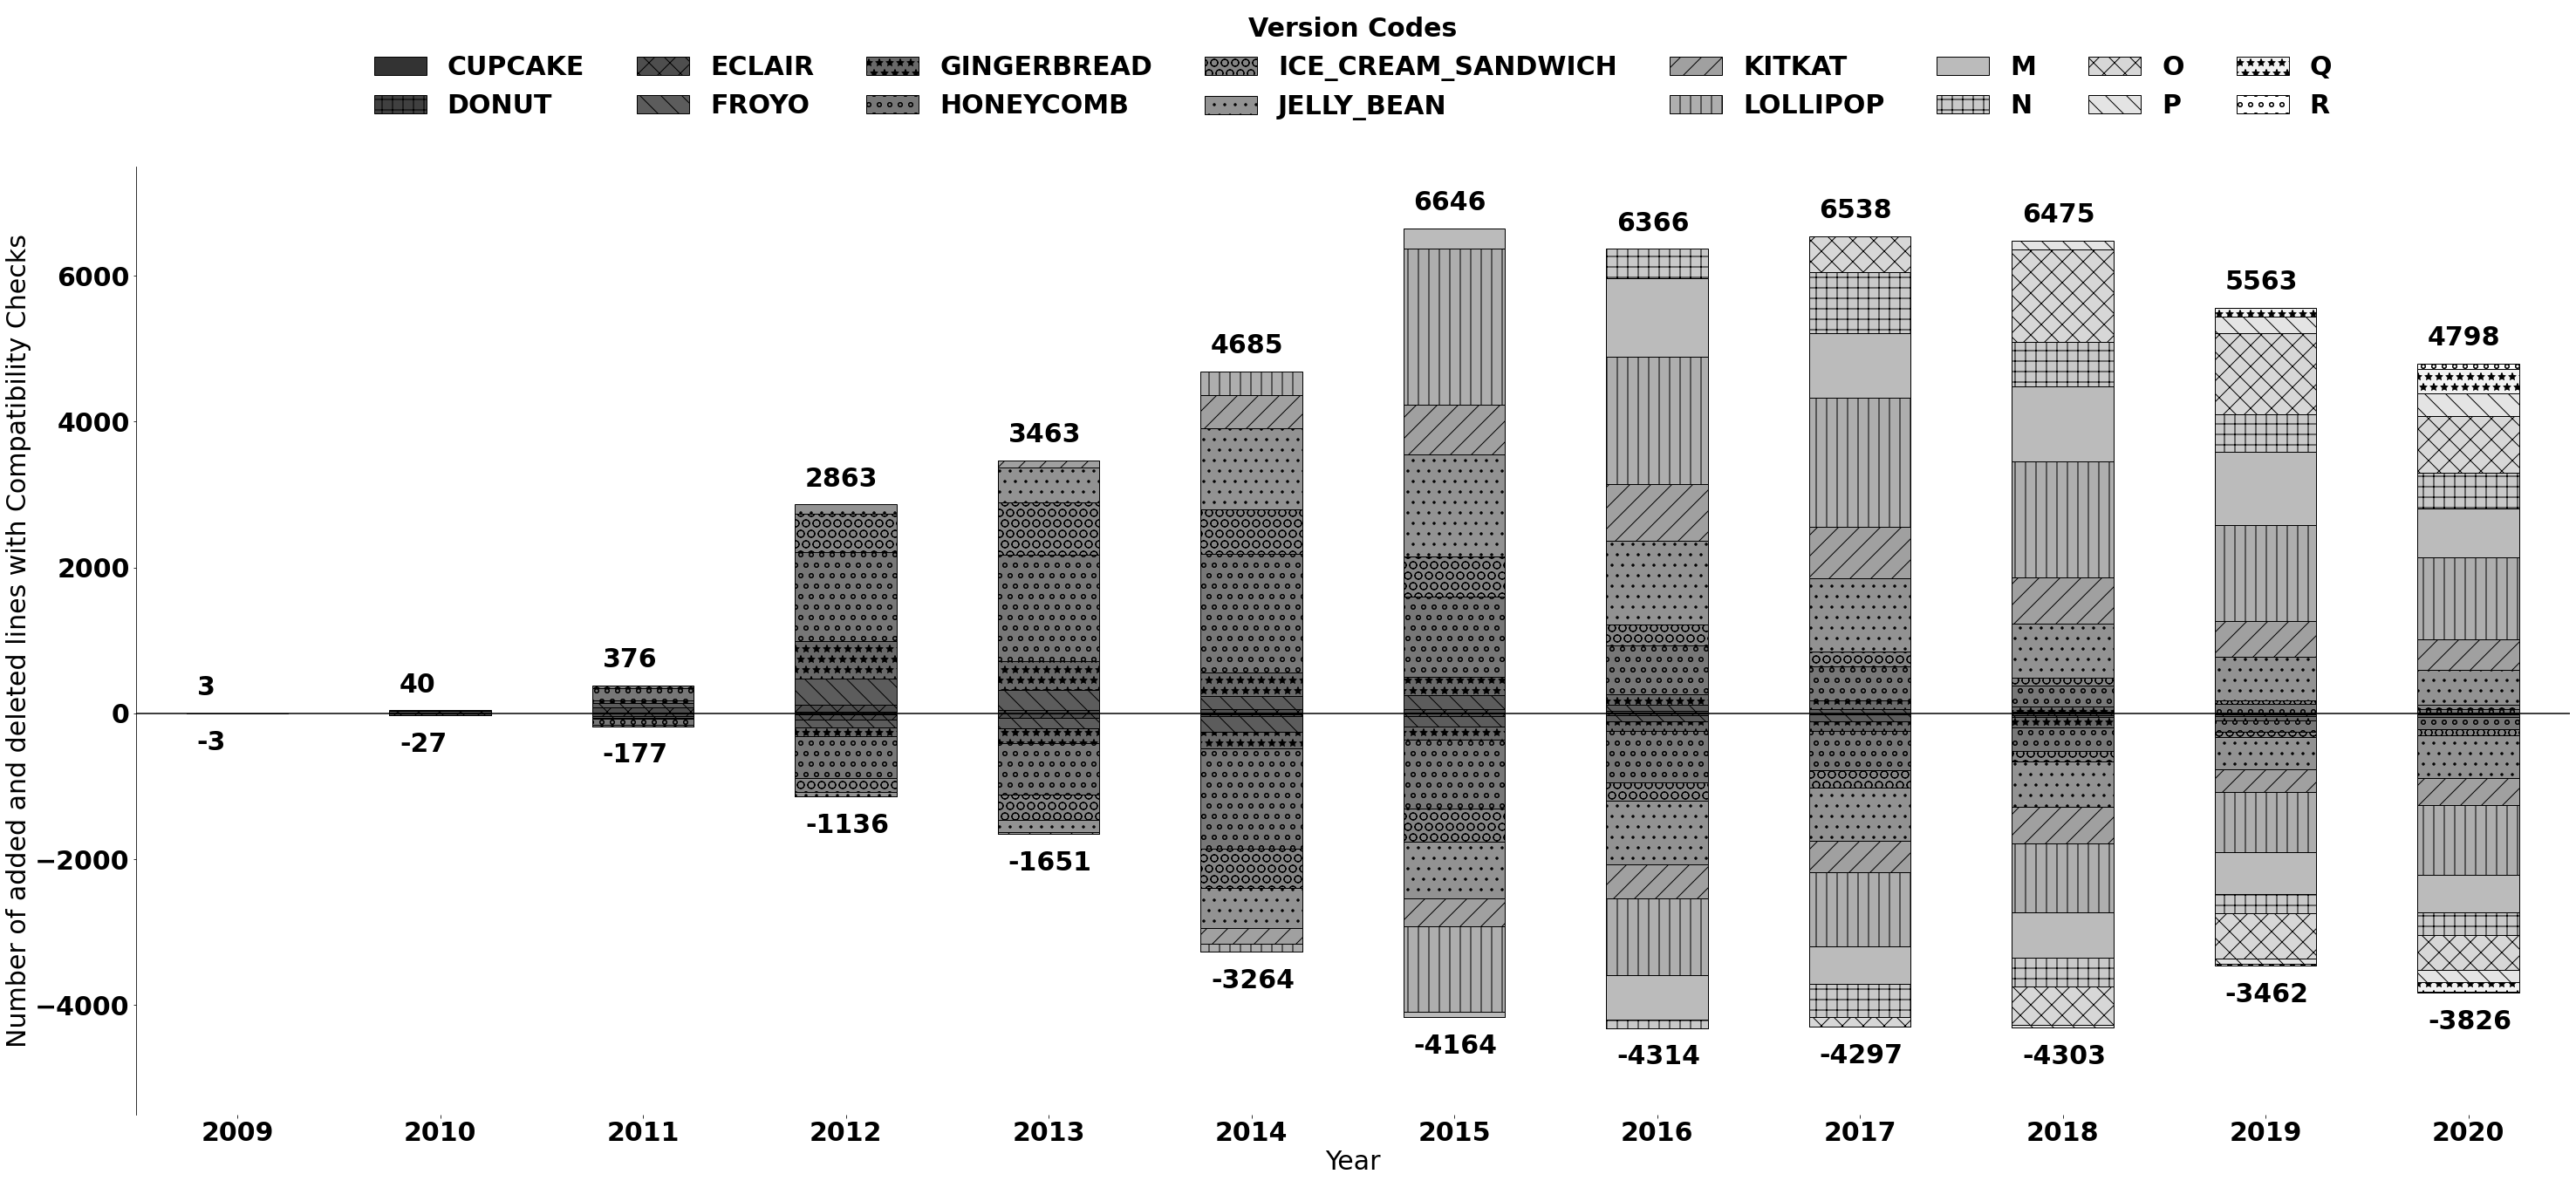

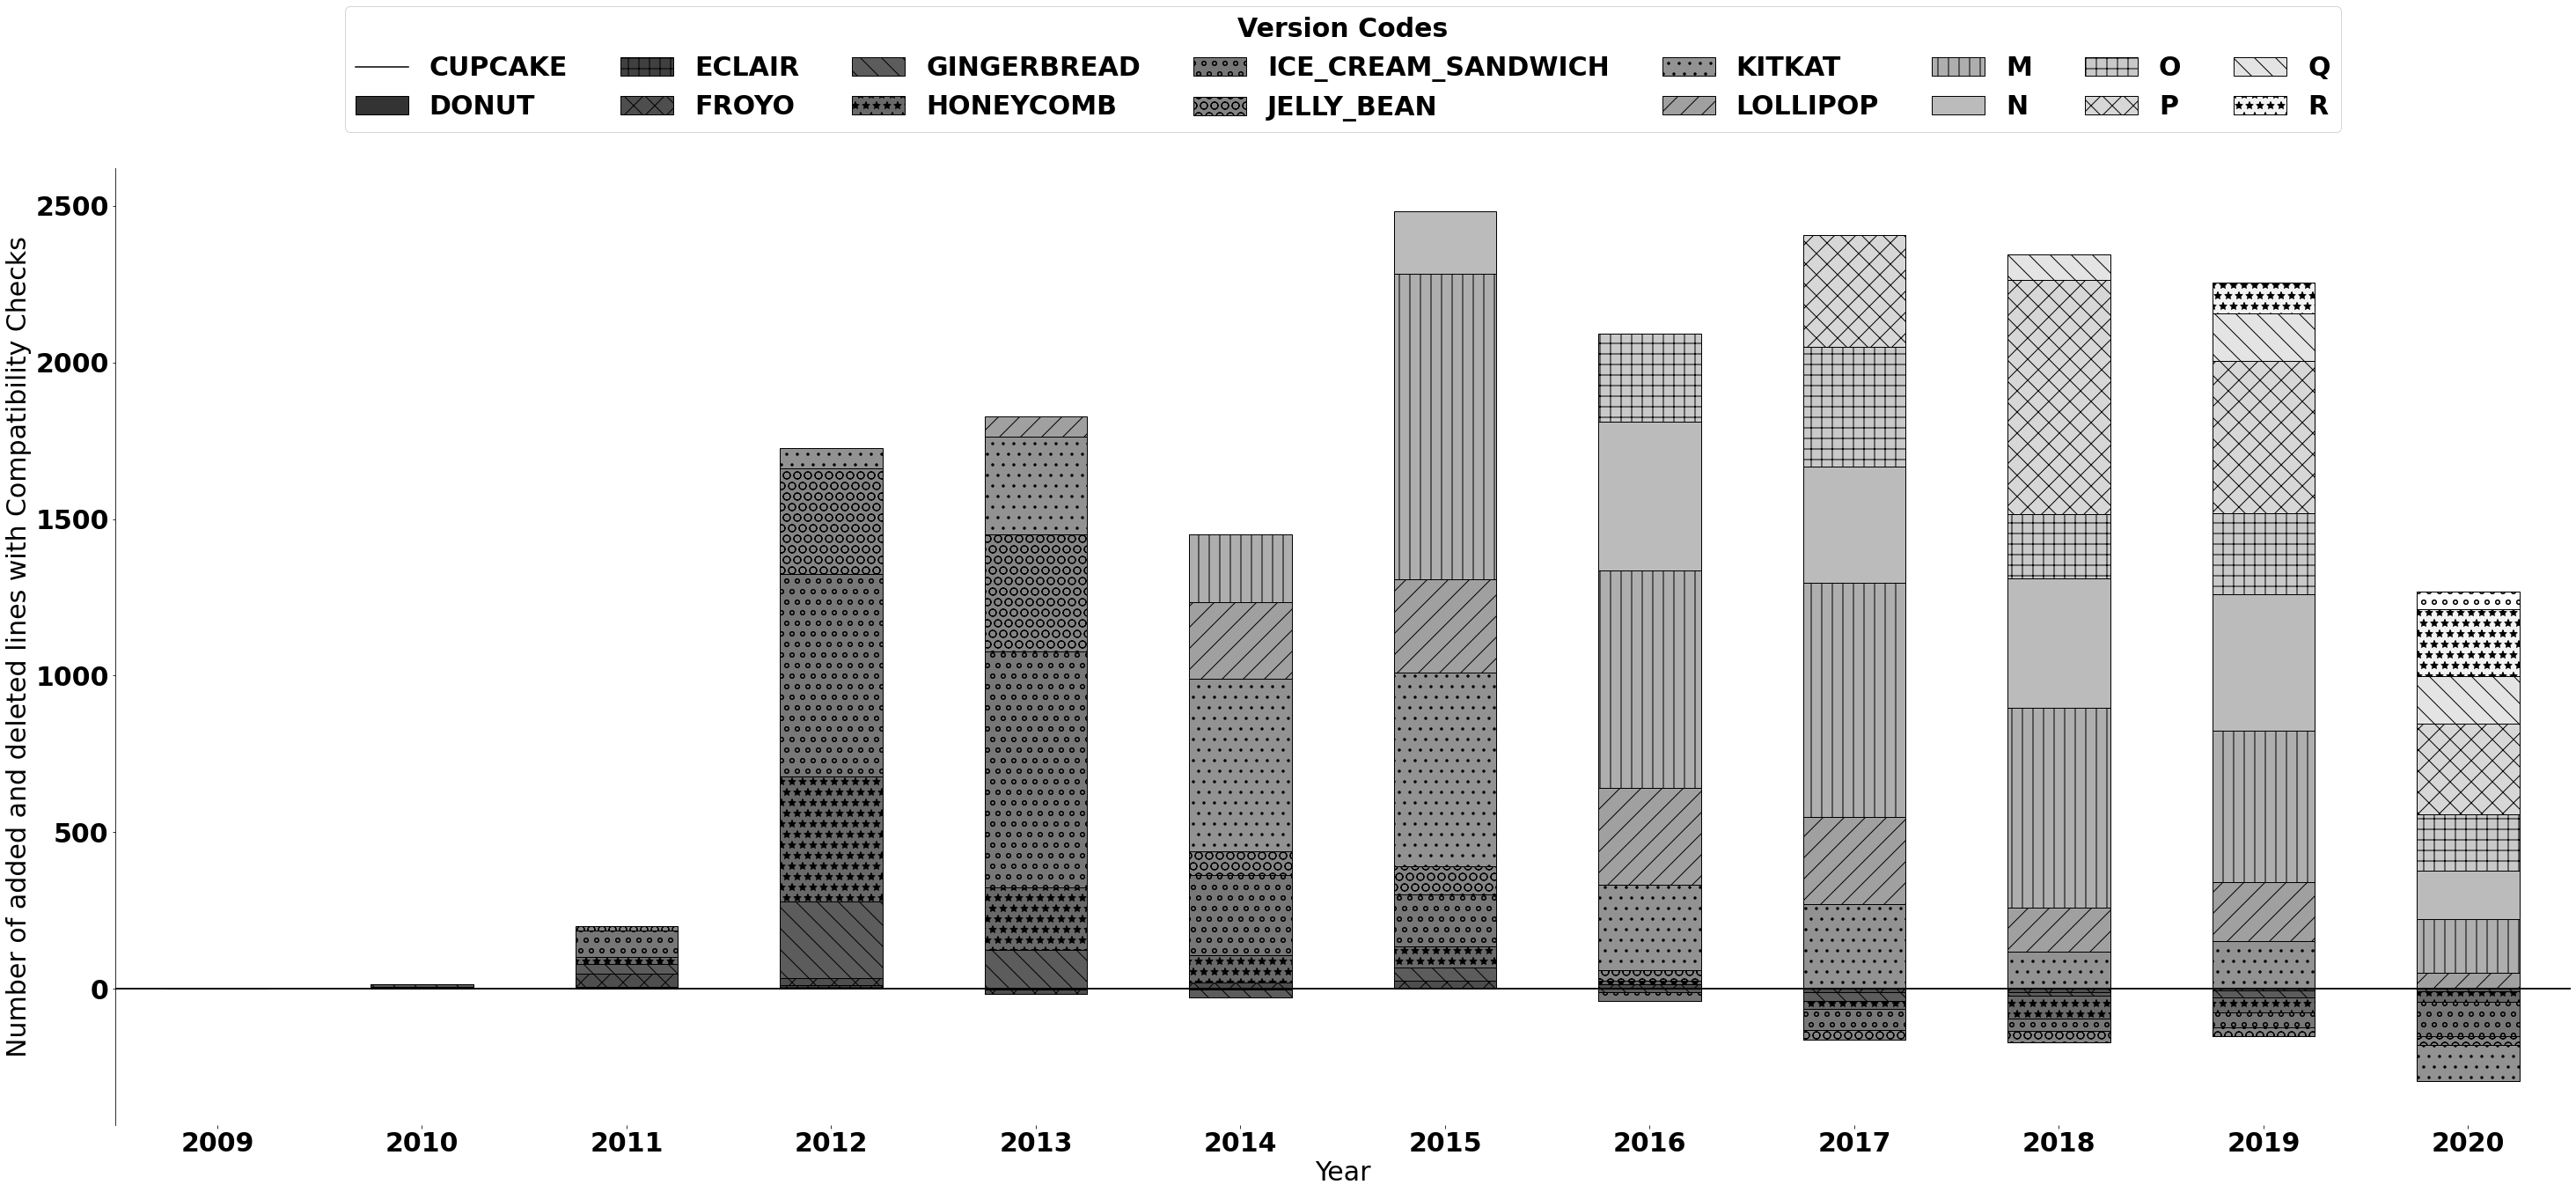

In [14]:
plot1 = count_added.unstack("version_merge")
plot2 = count_deleted.unstack("version_merge")
plot3 = count_balance.unstack("version_merge")

versions = changed_version["version_merge"].unique()
versions.sort()
pattern_zip = zip(versions,itertools.cycle(('', '+', 'x', '\\', '*', 'o', 'O', '.','/','|')))
pattern_match = {}
for key, hatch in pattern_zip:
    pattern_match[key]=hatch
versions = [v.replace("Build.VERSION_CODES.","") for v in versions]
num_versions = len(versions)
colors = plt.cm.gray(np.linspace(0.2,1,num_versions))

add_dict = {}
for year,num_add in zip(range(2009,2020+1),count_added_year):
    add_dict[year] = num_add
del_dict = {}
for year,num_del in zip(range(2009,2020+1),count_deleted_year):
    del_dict[year] = num_del

fig, ax = plt.subplots()
plot1.plot.bar(ax=ax,stacked=True,edgecolor='black',linewidth=1,color=colors,legend=None)
plot2.plot.bar(ax=ax,stacked=True,edgecolor='black',linewidth=1,color=colors,legend=None)

# add hatch
bars = [b for b in ax.containers if isinstance(b,mpl.container.BarContainer)]
for bar in bars:
    for patch in bar:
        patch.set_hatch(pattern_match.get(bar.get_label()))

ax.legend(versions,loc='upper center', title="Version Codes", bbox_to_anchor=(0.5, 1.1825), ncol=8,frameon=False)
ax.axhline(0,color="black")

#add text labels
xval = -0.2
shift = 1
delta = 500
for year in range(2009,2020+1):
    plt.text(x=xval, y=add_dict[year]+delta/2,s=add_dict[year])
    plt.text(x=xval, y=del_dict[year]-delta,s=del_dict[year])
    xval=xval+shift

# change xticks-labels
xlabels = []
for i in range(0,len(plt.xticks()[1])):
    xlabels.append(str(datetime.datetime.strptime(plt.xticks()[1][i].get_text(),"%Y-%m-%d %H:%M:%S").year))
ax.set_xticklabels(xlabels,rotation='horizontal')

#remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

plt.ylim(-5500,7500)
plt.xlabel("Year")
plt.ylabel("Number of added and deleted lines with Compatibility Checks")
#ax = plot3.plot.bar(stacked=True,edgecolor='black',linewidth=1,color=colors)
plt.savefig('../../data/F_out/android_version_compat_checks_changed_per_year.pdf')
plt.show()

fig, ax = plt.subplots()
plot3.plot.bar(ax=ax,stacked=True,edgecolor='black',linewidth=1,color=colors)

# add hatch
bars = [b for b in ax.containers if isinstance(b,mpl.container.BarContainer)]
for bar in bars:
    for patch in bar:
        patch.set_hatch(pattern_match.get(bar.get_label()))

ax.legend(versions,loc='upper center', title="Version Codes", bbox_to_anchor=(0.5, 1.1825), ncol=8,frameon=False)
ax.axhline(0,color="black")

ax.legend(versions,loc='upper center', title="Version Codes", bbox_to_anchor=(0.5, 1.1825), ncol=8)
ax.axhline(0,color="black")

# change xticks-labels
xlabels = []
for i in range(0,len(plt.xticks()[1])):
    xlabels.append(str(datetime.datetime.strptime(plt.xticks()[1][i].get_text(),"%Y-%m-%d %H:%M:%S").year))
ax.set_xticklabels(xlabels,rotation='horizontal')

#remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

#ax = plot3.plot.bar(stacked=True,edgecolor='black',linewidth=1,color=colors)
plt.xlabel("Year")
plt.ylabel("Number of added and deleted lines with Compatibility Checks")
plt.savefig('../../data/F_out/android_version_compat_checks_balanced_changed_per_year.pdf')
plt.show()

## Simple Method to detect the code guarded by the Compatibility Check

In [15]:
def extractGuardedCode(entry):
    # build regex to match code after compatibility check up to the first closing curely parenthesis (i.e., '}')
    regexString = ".*("+re.escape(entry["line"])+"[^\\}]*\\}).*"
    regex = re.compile(regexString, re.MULTILINE|re.DOTALL)
    
    # get repository and file path to the containing compatibiltiy (depends on whether it was added or deleted)
    repoMining = RepositoryMining(entry["repo_url"],single=entry["commit_hash"])
    filePath = None
    if(entry["change_action"]=="+++"):
        filePath = entry["new_path"].replace("/","\\")
    else:
        filePath = entry["old_path"].replace("/","\\")
    # traverse single commit
    for commit in repoMining.traverse_commits():
        # filter for relevant modification (i.e., relates to the changed file with the given change action and 
        # the changed line )
        changedFileModifications = [mod for mod in commit.modifications]
        lines_changed = []
        if(entry["change_action"]=="+++"):
            changedFileModifications = [mod for mod in changedFileModifications if mod.new_path!=None and filePath.endswith(mod.new_path)]
            for mod in changedFileModifications:
                lines_changed.extend(mod.diff_parsed["added"])
        else:
            changedFileModifications = [mod for mod in changedFileModifications if mod.old_path!=None and filePath.endswith(mod.old_path)]
            for mod in changedFileModifications:
                lines_changed.extend(mod.diff_parsed["deleted"])
        lines_changed =  [line[1].strip() for line in lines_changed if line[1].strip()==entry["line"]]
        # only return the changed code if there exist a single match
        if(len(lines_changed)==1):
            source_code = ""
            if(entry["change_action"]=="+++"):
                source_code = changedFileModifications[0].source_code
            else:
                source_code = changedFileModifications[0].source_code_before
            match = regex.match(source_code)
            return match.group(1)
        elif(len(lines_changed)>1):
            print("Multiple possible lines found")
            return "MULTIPLE_MATCHES"
        else:
            print("No code line found")
            return "NO_MATCHES"

In [16]:
####include to extract guarded code section - make take a while

#androidCompass["code_section"] = androidCompass.apply(lambda x: extractGuardedCode(x), axis=1)